# Max-Cut Optimization Problem

### Exploration of different algorithms for the Max-Cut problem

In [1]:
# useful additional packages
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import numpy as np
import networkx as nx
from aux_functions import draw_graph, brute_force_tsp, draw_tsp_solution
from time import time

from qiskit import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.problems import QuadraticProgram

# Max-Cut problem

In [2]:
n_wires = 4
nruns = 30 ### This should be set to a higher value to improve the results
#graph representing edge and weight
graph =  [(0, 1, 1.0), (0, 2, 1.0), (0, 3, 1.0), (1, 2, 1.0), (2, 3, 1.0)]

n_wires = 5
graph =  [(0, 1, 1.0), (0, 2, 1.0), (0, 3, 1.0), (0, 4, 1.0), (1, 2, 1.0), (1, 3, 1.0), (1, 4, 1.0), (3, 4, 1.0), (2, 4, 1.0), (2, 3, 1.0)]

n_wires = 6
graph =  [(0, 1, 1.0), (0, 2, 1.0), (0, 3, 1.0), (0, 4, 1.0), (0, 5, 1.0), 
(1, 2, 1.0), (1, 3, 1.0), (1, 4, 1.0), (1, 5, 1.0), (2, 3, 1.0), (2, 4, 1.0), (2, 5, 1.0),
(3, 4, 1.0), (3, 5, 1.0), (4, 5, 1.0)]

n_wires = 7
graph = [(0, 1, 1.0), (0, 2, 1.0), (0, 3, 1.0), (0, 4, 1.0), (0, 5, 1.0), 
(0, 6, 1.0), (1, 2, 1.0), (1, 3, 1.0), (1, 4, 1.0), (1, 5, 1.0), (1, 6, 1.0),
(2, 3, 1.0), (2, 4, 1.0), (2, 5, 1.0), (2, 6, 1.0), (3, 4, 1.0), (3, 5, 1.0), 
(3, 6, 1.0), (4, 5, 1.0), (4, 6, 1.0), (5, 6, 1.0)]

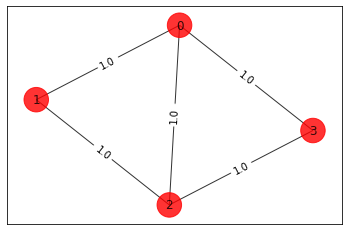

In [3]:
# Generating a graph of 4 nodes

n = n_wires  # Number of nodes in graph
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))
elist = graph
# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(elist)

colors = ["r" for node in G.nodes()]
pos = nx.spring_layout(G)

draw_graph(G, colors, pos)

In [4]:
# Computing the weight matrix from the random graph
w = np.zeros([n, n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i, j, default=0)
        if temp != 0:
            w[i, j] = temp["weight"]
print(w)

[[0. 1. 1. 1.]
 [1. 0. 1. 0.]
 [1. 1. 0. 1.]
 [1. 0. 1. 0.]]


### Brute force approach

Try all possible $2^n$ combinations. For $n = 4$, as in this example, one deals with only 16 combinations, but for n = 1000, one has 1.071509e+30 combinations, which is impractical to deal with by using a brute force approach. 

In [5]:
time_start = time()

best_cost_brute = 0
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i, j] * x[i] * (1 - x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x
    print("case = " + str(x) + " cost = " + str(cost))

time_end = time()
time_elapsed_bf = time_end - time_start
print(f"Elapsed time: {time_elapsed_bf} s")
    
#colors = ["r" if xbest_brute[i] == 0 else "c" for i in range(n)]
#draw_graph(G, colors, pos)
print("\nBest solution = " + str(xbest_brute) + " cost = " + str(best_cost_brute))



case = [0, 0, 0, 0] cost = 0.0
case = [1, 0, 0, 0] cost = 3.0
case = [0, 1, 0, 0] cost = 2.0
case = [1, 1, 0, 0] cost = 3.0
case = [0, 0, 1, 0] cost = 3.0
case = [1, 0, 1, 0] cost = 4.0
case = [0, 1, 1, 0] cost = 3.0
case = [1, 1, 1, 0] cost = 2.0
case = [0, 0, 0, 1] cost = 2.0
case = [1, 0, 0, 1] cost = 3.0
case = [0, 1, 0, 1] cost = 4.0
case = [1, 1, 0, 1] cost = 3.0
case = [0, 0, 1, 1] cost = 3.0
case = [1, 0, 1, 1] cost = 2.0
case = [0, 1, 1, 1] cost = 3.0
case = [1, 1, 1, 1] cost = 0.0
Elapsed time: 0.0009284019470214844 s

Best solution = [1, 0, 1, 0] cost = 4.0


# VQE for Max-Cut with Qiskit

### Mapping to the Ising problem

Qiskit provides functionality to generate `QuadraticProgram` from the problem specification as well as create the corresponding Ising Hamiltonian.


In [6]:
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
print(qp.prettyprint())

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_2 - 2*x_0*x_3 - 2*x_1*x_2 - 2*x_2*x_3 + 3*x_0 + 2*x_1
  + 3*x_2 + 2*x_3

Subject to
  No constraints

  Binary variables (4)
    x_0 x_1 x_2 x_3



In [7]:
qubitOp, offset = qp.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: -2.5
Ising Hamiltonian:
0.5 * IIZZ
+ 0.5 * IZIZ
+ 0.5 * IZZI
+ 0.5 * ZIIZ
+ 0.5 * ZZII


In [8]:
# solving Quadratic Program using exact classical eigensolver
time_start = time()

exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qp)
print(result.prettyprint())

time_end = time()
time_elapsed_class_Is = time_end - time_start
print(f"Elapsed time: {time_elapsed_class_Is} s")

objective function value: 4.0
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0
status: SUCCESS
Elapsed time: 0.02394843101501465 s


Since the problem was cast to a minimization problem, the solution of $-4$ corresponds to the optimum.

### Checking that the full Hamiltonian gives the right cost 

In [9]:
# Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = NumPyMinimumEigensolver()
result = ee.compute_minimum_eigenvalue(qubitOp)

x = max_cut.sample_most_likely(result.eigenstate)
print("energy:", result.eigenvalue.real)
print("max-cut objective:", result.eigenvalue.real + offset)
print("solution:", x)
print("solution objective:", qp.objective.evaluate(x))

#colors = ["r" if x[i] == 0 else "c" for i in range(n)]
#draw_graph(G, colors, pos)

energy: -1.5
max-cut objective: -4.0
solution: [1 0 1 0]
solution objective: 4.0


### Running it on quantum computer
We run the optimization routine using a feedback loop with a quantum computer that uses trial functions built with Y single-qubit rotations, $U_\mathrm{single}(\theta) = \prod_{i=1}^n Y(\theta_{i})$, and entangler steps $U_\mathrm{entangler}$.

In [10]:
algorithm_globals.random_seed = 123
seed = 10598
backend = Aer.get_backend("aer_simulator_statevector")
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

In [11]:
# construct VQE
spsa = SPSA(maxiter=300)
ry = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=nruns, entanglement="linear", insert_barriers=True)

###  The TwoLocal is a parameterized circuit consisting of alternating rotation layers and entanglement layers

vqe = VQE(ry, optimizer=spsa, quantum_instance=quantum_instance)

time_start = time()

# run VQE
result = vqe.compute_minimum_eigenvalue(qubitOp)

time_end = time()
time_elapsed_VQE_Aer = time_end - time_start
print(f"Elapsed time: {time_elapsed_VQE_Aer} s")

# print results
x = max_cut.sample_most_likely(result.eigenstate)
print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
print("max-cut objective:", result.eigenvalue.real + offset)
print("solution:", x)
print("solution objective:", qp.objective.evaluate(x))

# plot results
#colors = ["r" if x[i] == 0 else "c" for i in range(n)]
#draw_graph(G, colors, pos)

Elapsed time: 12.164220333099365 s
energy: -1.4271839912312043
time: 11.900036811828613
max-cut objective: -3.927183991231204
solution: [0. 1. 0. 1.]
solution objective: 4.0


objective function value: 4.0
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0
status: SUCCESS


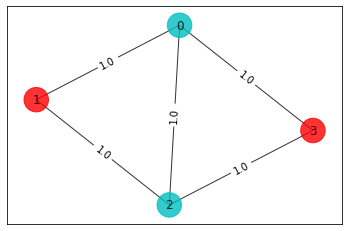

In [12]:
# create minimum eigen optimizer based on VQE
vqe_optimizer = MinimumEigenOptimizer(vqe)

# solve quadratic program
result = vqe_optimizer.solve(qp)
print(result.prettyprint())

colors = ["r" if result.x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

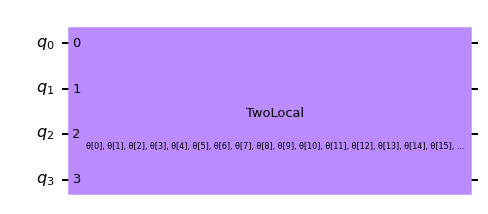

In [13]:
ry.draw("mpl")

# QAOA for Max-Cut with Pennylane

In [14]:
import pennylane as qml
from pennylane import numpy as np

np.random.seed(42)

### Operators

We specify the number of qubits (vertices) with `n_wires` and compose the unitary operators using the definitions above. $U_B$ operators act on individual wires, while $U_C$ operators act on wires whose corresponding vertices are joined by an edge in the graph. We also define the graph using the list `graph`, which contains the tuples of vertices defining each edge in the graph

In [15]:
n_wires = n_wires
graph = graph

# unitary operator U_B with parameter beta
def U_B(beta):
    for wire in range(n_wires):
        qml.RX(2 * beta, wires=wire)


# unitary operator U_C with parameter gamma
def U_C(gamma):
    for edge in graph:
        wire1 = edge[0]
        wire2 = edge[1]
        qml.CNOT(wires=[wire1, wire2])
        qml.RZ(gamma, wires=wire2)
        qml.CNOT(wires=[wire1, wire2])

We will need a way to convert a bitstring, representing a sample of multiple qubits in the computational basis, to integer or base-10 form.

In [16]:
def bitstring_to_int(bit_string_sample):
    bit_string = "".join(str(bs) for bs in bit_string_sample)
    return int(bit_string, base=2)

### Circuit

Next, we create a quantum device with 4 qubits.

In [17]:
simulation_framework = "cirq.simulator"   #  "lightning.qubit"
dev = qml.device(simulation_framework, wires=n_wires, shots=1)

We also require a quantum node which will apply the operators according to the angle parameters, and return the expectation value of the observable $\sigma_z^{j}\sigma_z^{k}$ to be used in each term of the objective function later on. The argument `edge` specifies the chosen edge term in the objective function, $(j,k)$. Once optimized, the same quantum node can be used for sampling an approximately optimal bitstring if executed with the `edge` keyword set to `None`. Additionally, we specify the number of layers (repeated applications of $U_BU_C$) using the keyword `n_layers`.

In [18]:
@qml.qnode(dev)

def circuit(gammas, betas, edge=None, n_layers=1):
    # apply Hadamards to get the n qubit |+> state
    for wire in range(n_wires):
        qml.Hadamard(wires=wire)
    # p instances of unitary operators
    for i in range(n_layers):
        U_C(gammas[i])
        U_B(betas[i])
    if edge is None:
        # measurement phase
        return qml.sample()
    # during the optimization phase we are evaluating a term
    # in the objective using expval
    H = qml.PauliZ(edge[0]) @ qml.PauliZ(edge[1])
    return qml.expval(H)

### Optimization

Finally, we optimize the objective over the angle parameters $\boldsymbol{\gamma}$ (`params[0]`) and $\boldsymbol{\beta}$(`params[1]`) and then sample the optimized circuit multiple times to yield a distribution of bitstrings. One of the optimal partitions\n($z=0101$ or $z=1010$) should be the most frequently sampled bitstring. We perform a maximization of $C$ by minimizing $-C$, following the convention that optimizations are cast as minimizations in PennyLane.

In [19]:
def qaoa_maxcut(n_layers=1):
    print("\nLayers={:d}".format(n_layers))

    # initialize the parameters near zero
    init_params = 0.01 * np.random.rand(2, n_layers, requires_grad=True)

    # minimize the negative of the objective function
    def objective(params):
        gammas = params[0]
        betas = params[1]
        neg_obj = 0
        for edge in graph:
            # objective for the MaxCut problem
            neg_obj -= 0.5 * (1 - circuit(gammas, betas, edge=edge, n_layers=n_layers))
        return neg_obj

    # initialize optimizer: Adagrad works well empirically
    opt = qml.AdagradOptimizer(stepsize=0.5)

    # optimize parameters in objective
    params = init_params
    steps = nruns
    for i in range(steps):
        params = opt.step(objective, params)
        if (i + 1) % 5 == 0:
            print("Objective after step {:5d}: {: .7f}".format(i + 1, -objective(params)))

    # sample measured bitstrings 100 times
    bit_strings = []
    n_samples = 100
    for i in range(0, n_samples):
        bit_strings.append(bitstring_to_int(circuit(params[0], params[1], edge=None, n_layers=n_layers)))

    # print optimal parameters and most frequently sampled bitstring
    counts = np.bincount(np.array(bit_strings))
    most_freq_bit_string = np.argmax(counts)
    print("Optimized (gamma, beta) vectors:\n{}".format(params[:, :n_layers]))
    print("Most frequently sampled bit string is: {:04b}".format(most_freq_bit_string))

    return -objective(params), bit_strings

In [20]:
# perform qaoa on our graph with p=1,2 and
# keep the bitstring sample lists

time_start = time()

bitstrings1 = qaoa_maxcut(n_layers=1)[1]

time_end = time()
time_elapsed_QAOA_Penny = time_end - time_start
print(f"Elapsed time: {time_elapsed_QAOA_Penny} s")

bitstrings2 = qaoa_maxcut(n_layers=2)[1]


Layers=1
Objective after step     5:  2.0000000
Objective after step    10:  2.0000000
Objective after step    15:  4.0000000
Objective after step    20:  2.0000000
Objective after step    25:  3.0000000
Objective after step    30:  4.0000000
Optimized (gamma, beta) vectors:
[[ 0.51568398]
 [-0.29626509]]
Most frequently sampled bit string is: 0101
Elapsed time: 18.54031729698181 s

Layers=2
Objective after step     5:  2.0000000
Objective after step    10:  1.0000000
Objective after step    15:  4.0000000
Objective after step    20:  3.0000000
Objective after step    25:  2.0000000
Objective after step    30:  4.0000000
Optimized (gamma, beta) vectors:
[[ 0.33439315 -0.52539691]
 [ 0.82261445  0.22441945]]
Most frequently sampled bit string is: 0101


In [21]:
if simulation_framework == "cirq.simulator":
    print(dev.circuit)

                                                    ┌──┐                ┌──┐                                                                              ┌──┐                 ┌──┐
0: ───H───@────────────────@───@────────────────@────@───────────────────@─────Rx(0.524π)───@──────────────────────────@────────────@─────────────────@────@────────────────────@─────Rx(0.143π)───M('0')──────────────────────────────────
          │                │   │                │    │                   │                  │                          │            │                 │    │                    │
1: ───H───X───Rz(0.106π)───X───┼────────────────┼────┼@──────────────────┼@────Rx(0.524π)───X────────────Rz(-0.167π)───X────────────┼─────────────────┼────┼@───────────────────┼@────Rx(0.143π)───M('1')──────────────────────────────────
                               │                │    ││                  ││                                                         │                 │    ││             

### Plotting the results

We can plot the distribution of measurements obtained from the optimized circuits. As expected for this graph, the partitions 0101 and 1010 are measured with the highest frequencies.

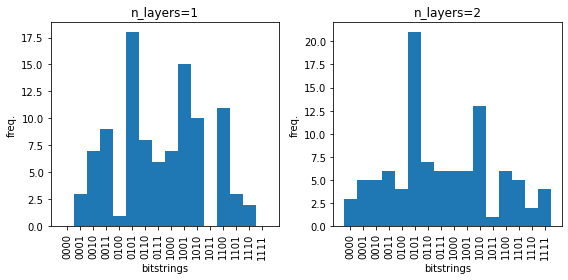

In [22]:
xticks = range(0, 16)
xtick_labels = list(map(lambda x: format(x, "04b"), xticks))
bins = np.arange(0, 17) - 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("n_layers=1")
plt.xlabel("bitstrings")
plt.ylabel("freq.")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(bitstrings1, bins=bins)
plt.subplot(1, 2, 2)
plt.title("n_layers=2")
plt.xlabel("bitstrings")
plt.ylabel("freq.")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(bitstrings2, bins=bins)
plt.tight_layout()
plt.show()

# QUBO for Max-Cut solved with D-WAVE

In [23]:
# ------ Import necessary packages ----
from collections import defaultdict

from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite

### We use the same graph as in the previous cases

### Set up the QUBO dictionary

Initialize our h vector, J matrix, and then update the J matrix for every edge in the graph

In [24]:
h = defaultdict(int)
J = defaultdict(int)
for i, j in G.edges:
    J[(i,j)]+= G[i][j]['weight']
    
### J is the w that we have defined previously

### Run out QUBO on the QPU

Set up the parameters

In [25]:
chainstrength = 2

Run the QUBO on the solver from the config file

In [27]:
sampler = EmbeddingComposite(DWaveSampler(token='DEV-0a1fb36e5388514f43fd5dc4331d4f96617c918c'))

time_start = time()

response = sampler.sample_ising(h, J,
                                chain_strength=chainstrength,
                                num_reads=nruns,
                                label='Example - Maximum Cut Ising')

time_end = time()
time_elapsed_QUBO_Dwave = time_end - time_start
print(f"Elapsed time: {time_elapsed_QUBO_Dwave} s")

Elapsed time: 0.0807797908782959 s


### Print results

In [28]:
print('-' * 60)
print('{:>15s}{:>15s}{:^15s}{:^15s}'.format('Set 0','Set 1','Energy','Cut Size'))
print('-' * 60)
for sample, E in response.data(fields=['sample','energy']):
    S0 = [k for k,v in sample.items() if v == -1]
    S1 = [k for k,v in sample.items() if v == 1]
    print('{:>15s}{:>15s}{:^15s}{:^15s}'.format(str(S0),str(S1),str(E),str(int((6-E)/2))))

------------------------------------------------------------
          Set 0          Set 1    Energy        Cut Size    
------------------------------------------------------------
         [0, 2]         [1, 3]     -3.0             4       
         [1, 3]         [0, 2]     -3.0             4       


In [29]:
response

SampleSet(rec.array([([-1,  1, -1,  1], -3., 20, 0.),
           ([ 1, -1,  1, -1], -3., 10, 0.)],
          dtype=[('sample', 'i1', (4,)), ('energy', '<f8'), ('num_occurrences', '<i8'), ('chain_break_fraction', '<f8')]), Variables([0, 1, 2, 3]), {'timing': {'qpu_sampling_time': 2652.0, 'qpu_anneal_time_per_sample': 20.0, 'qpu_readout_time_per_sample': 47.86, 'qpu_access_time': 18410.77, 'qpu_access_overhead_time': 1677.23, 'qpu_programming_time': 15758.77, 'qpu_delay_time_per_sample': 20.54, 'total_post_processing_time': 3680.0, 'post_processing_overhead_time': 3680.0}, 'problem_id': 'f3bc0c34-d5d2-45da-ab12-37a3cd165b7e', 'problem_label': 'Example - Maximum Cut Ising'}, 'SPIN')

### Display results

 Grab best result. 
 Note: "best" result is the result with the lowest energy. 
 Note2: the look up table (lut) is a dictionary, where the key is the node index
   and the value is the set label. For example, lut[5] = 1, indicates that
   node 5 is in set 1 (S1).

In [30]:
lut = response.first.sample

In [31]:
# Interpret best result in terms of nodes and edges
S0 = [node for node in G.nodes if lut[node]==-1]
S1 = [node for node in G.nodes if lut[node]==1]
cut_edges = [(u, v) for u, v in G.edges if lut[u]!=lut[v]]
uncut_edges = [(u, v) for u, v in G.edges if lut[u]==lut[v]]

{0: Text(-0.37557055824697594, 0.4662272157998906, '0'),
 1: Text(-1.0, -0.8055409242669958, '1'),
 2: Text(0.3755819867880224, -0.4662414058276999, '2'),
 3: Text(0.9999885714589536, 0.8055551142948052, '3')}

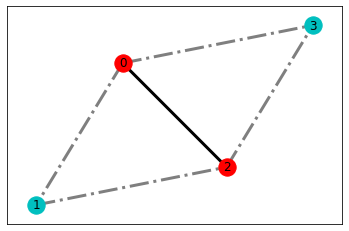

In [32]:
# Display best result
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, nodelist=S0, node_color='r')
nx.draw_networkx_nodes(G, pos, nodelist=S1, node_color='c')
nx.draw_networkx_edges(G, pos, edgelist=cut_edges, style='dashdot', alpha=0.5, width=3)
nx.draw_networkx_edges(G, pos, edgelist=uncut_edges, style='solid', width=3)
nx.draw_networkx_labels(G, pos)

In [33]:
#filename = "maxcut_plot_ising.png"
#plt.savefig(filename, bbox_inches='tight')
#print("\nYour plot is saved to {}".format(filename))

In [34]:
results = [n_wires, time_elapsed_bf, time_elapsed_class_Is, time_elapsed_VQE_Aer, time_elapsed_QAOA_Penny, time_elapsed_QUBO_Dwave]
results

[4,
 0.0009284019470214844,
 0.02394843101501465,
 12.164220333099365,
 18.54031729698181,
 0.0807797908782959]